In [1]:
root="dataRaw"

files :  ['.ipynb_checkpoints', '0A32eTdBKayjCWhZqDOQ.bytes', '0A32eTdBKayjCWhZqDOQ.bytes.png', '0ACDbR5M3ZhBJajygTuf.bytes', '0ACDbR5M3ZhBJajygTuf.bytes.png']
Processing 0A32eTdBKayjCWhZqDOQ.bytes


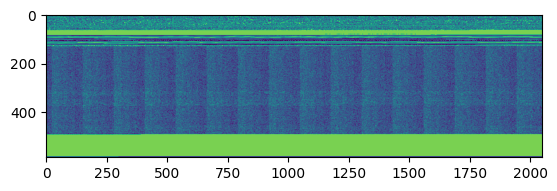

Processing 0ACDbR5M3ZhBJajygTuf.bytes


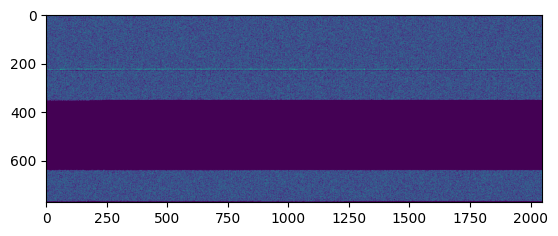

In [2]:
import sys
import os
from math import log
import numpy as np
import scipy as sp
from PIL import Image
import matplotlib.pyplot as plt

## This function allows us to process our hexadecimal files into png images##
def convertAndSave(array,name):
    print('Processing '+name)
    if array.shape[1]!=16: #If not hexadecimal
        assert(False)
    b=int((array.shape[0]*16)**(0.5))
    b=2**(int(log(b)/log(2))+1)
    a=int(array.shape[0]*16/b)
    array=array[:a*b//16,:]
    array=np.reshape(array,(a,b))
    im = Image.fromarray(np.uint8(array))
    im.save(root+'\\'+name+'.png', "PNG")
    return im

#Get the list of files
files=os.listdir(root)
print('files : ',files)
#We will process files one by one.
for counter, name in enumerate(files):
        #We only process .bytes files from our folder.
        if '.bytes' != name[-6:]:
            continue
        f=open(root+'/'+name)
        array=[]
        for line in f:
            xx=line.split()
            if len(xx)!=17:
                continue
            array.append([int(i,16) if i!='??' else 0 for i in xx[1:] ])
        plt.imshow(convertAndSave(np.array(array),name))
        plt.show()
        del array
        f.close()

In [3]:
path_root = "malimg_paper_dataset_imgs\\"

In [4]:

from keras.preprocessing.image import ImageDataGenerator
batches = ImageDataGenerator().flow_from_directory(directory=path_root, target_size=(64,64), batch_size=10000)

Found 9339 images belonging to 25 classes.


In [5]:
batches.class_indices

{'Adialer.C': 0,
 'Agent.FYI': 1,
 'Allaple.A': 2,
 'Allaple.L': 3,
 'Alueron.gen!J': 4,
 'Autorun.K': 5,
 'C2LOP.P': 6,
 'C2LOP.gen!g': 7,
 'Dialplatform.B': 8,
 'Dontovo.A': 9,
 'Fakerean': 10,
 'Instantaccess': 11,
 'Lolyda.AA1': 12,
 'Lolyda.AA2': 13,
 'Lolyda.AA3': 14,
 'Lolyda.AT': 15,
 'Malex.gen!J': 16,
 'Obfuscator.AD': 17,
 'Rbot!gen': 18,
 'Skintrim.N': 19,
 'Swizzor.gen!E': 20,
 'Swizzor.gen!I': 21,
 'VB.AT': 22,
 'Wintrim.BX': 23,
 'Yuner.A': 24}

In [6]:
imgs, labels = next(batches)

In [7]:
imgs.shape

(9339, 64, 64, 3)

In [8]:
labels.shape

(9339, 25)

In [9]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(20,30), rows=10, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = 10 # len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(0,50):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(list(batches.class_indices.keys())[np.argmax(titles[i])], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')
    plt.show() 

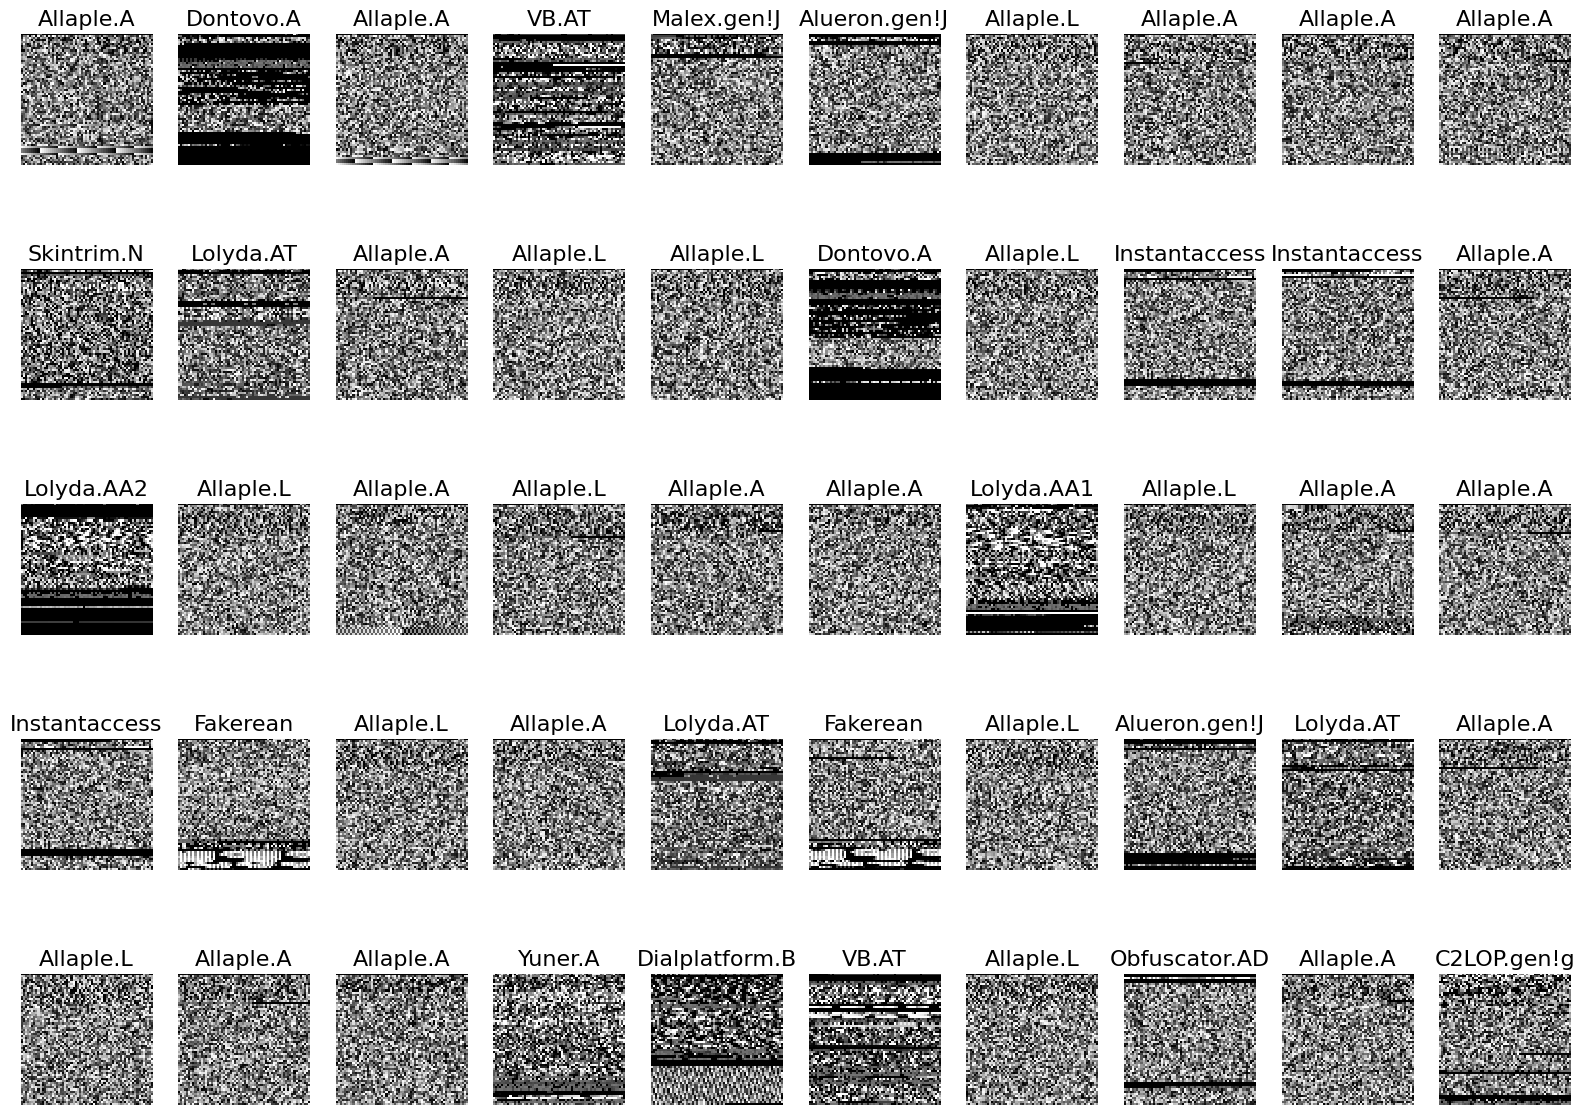

In [10]:
plots(imgs, titles = labels)

In [11]:
classes = batches.class_indices.keys()

In [12]:
perc = (sum(labels)/labels.shape[0])*100

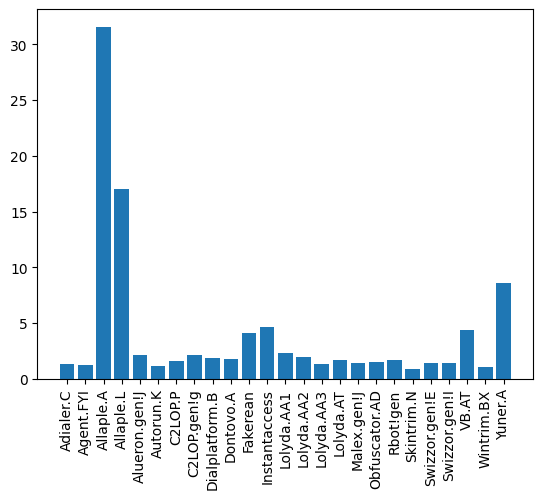

In [13]:
plt.xticks(rotation='vertical')
plt.bar(classes,perc)
plt.show()

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(imgs/255.,labels, test_size=0.3)

In [15]:
X_train.shape

(6537, 64, 64, 3)

In [16]:
X_test.shape

(2802, 64, 64, 3)

In [17]:
y_train.shape

(6537, 25)

In [18]:
y_test.shape

(2802, 25)

In [19]:
import keras
from keras.models import Sequential, Input, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization

In [20]:
num_classes = 25

In [21]:
def malware_model():
    Malware_model = Sequential()
    Malware_model.add(Conv2D(30, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(64,64,3)))

    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    Malware_model.add(Conv2D(15, (3, 3), activation='relu',))
    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    Malware_model.add(Dropout(0.25))
    Malware_model.add(Flatten())
    Malware_model.add(Dense(128, activation='relu'))
    Malware_model.add(Dropout(0.5))
    Malware_model.add(Dense(50, activation='relu'))
    Malware_model.add(Dense(num_classes, activation='softmax'))
    Malware_model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
    return Malware_model

In [22]:
Malware_model = malware_model()

In [23]:
Malware_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 30)        840       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 30)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 15)        4065      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 15)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 15)        0         
_________________________________________________________________
flatten (Flatten)            (None, 2940)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               3

In [24]:
y_train.shape

(6537, 25)

In [25]:
y_train_new = np.argmax(y_train, axis=1)


In [26]:
y_train_new

array([ 2,  2,  6, ...,  3, 24,  2], dtype=int64)

In [27]:

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',np.unique(y_train_new),y_train_new)
class_weights = dict(enumerate(class_weights))

C:\Users\Andres\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24], y=[ 2  2  6 ...  3 24  2] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [28]:
Malware_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10,  class_weight=class_weights)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/10
205/205 [==============================] - 11s 14ms/step - loss: 2.1812 - accuracy: 0.2913 - val_loss: 1.0926 - val_accuracy: 0.6813744 - 
Epoch 2/10
205/205 [==============================] - 2s 9ms/step - loss: 0.8537 - accuracy: 0.5507 - val_loss: 0.8150 - val_accuracy: 0.6053
Epoch 3/10
205/205 [==============================] - 2s 9ms/step - loss: 0.6157 - accuracy: 0.6387 - val_loss: 0.4982 - val_accuracy: 0.8701
Epoch 4/10
205/205 [==============================] - 2s 9ms/step - loss: 0.4995 - accuracy: 0.7006 - val_loss: 0.4412 - val_accuracy: 0.9076
Epoch 5/10
205/205 [==============================] - 2s 9ms/step - loss: 0.4448 - accuracy: 0.7343 - val_loss: 0.4699 - val_accuracy: 0.8851
Epoch 6/10
205/205 [==============================] - 2s 9ms/step - loss: 0.3668 - accuracy: 0.7837 - val_loss: 0.3657 - val_accuracy: 0.9126
Ep

In [29]:
scores = Malware_model.evaluate(X_test, y_test)


88/88 [==============================] - 0s 5ms/step - loss: 0.2248 - accuracy: 0.9461


In [30]:
print('Final CNN loss, scores[0])
print('Final CNN accuracy: ', scores[1])

Final CNN accuracy:  0.22476626932621002
Final CNN accuracy:  0.94610995054245


In [31]:
import numpy as np
import pandas as pd

In [32]:
y_pred = Malware_model.predict_classes(X_test, verbose=0)

C:\Users\Andres\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [33]:
y_pred

array([ 9,  0,  4, ...,  2,  7, 24], dtype=int64)

In [34]:
y_test2 = np.argmax(y_test, axis=1)

In [35]:
y_test2

array([9, 0, 4, ..., 2, 7, 5], dtype=int64)

In [36]:
from sklearn import metrics
c_matrix = metrics.confusion_matrix(y_test2, y_pred)

In [37]:
import seaborn as sns
def confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

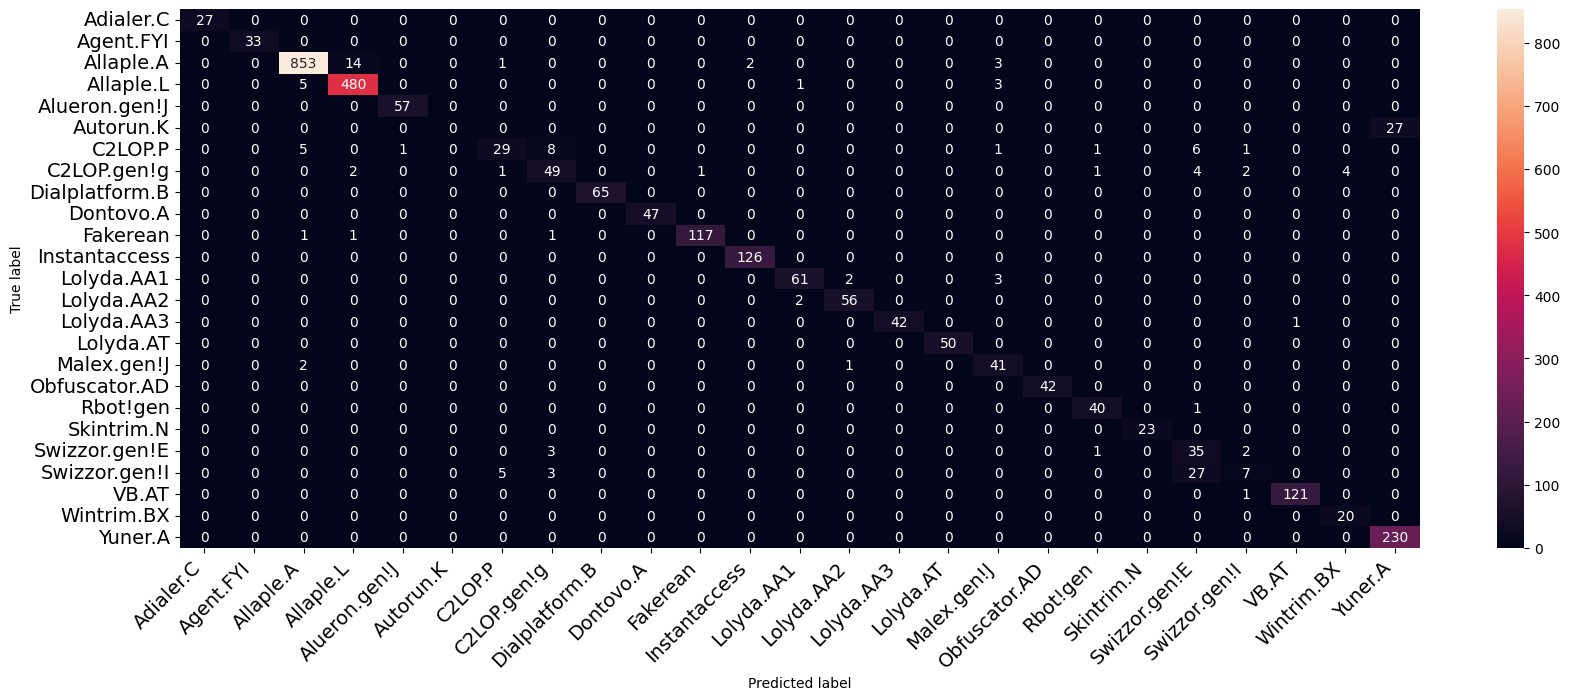

In [38]:
import matplotlib.pyplot as plt

class_names= batches.class_indices.keys()
matrix = confusion_matrix(c_matrix, class_names, figsize = (20,7), fontsize=14)
plt.show()